In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from charset_normalizer import md__mypyc
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet101
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Flatten, Input, Concatenate
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential
from keras.applications.xception import Xception
from keras.layers import BatchNormalization, Activation, Dropout, MaxPooling2D,Conv2D
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import time
import os


2023-04-12 19:23:28.458125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 19:23:29.295749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/christian/miniconda3/envs/tf/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Import Training and test data

In [2]:
size = 48
num_classes = 6
NUM_EPOCHS = 10

In [3]:
from keras import backend as K

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

auc_metric = tf.keras.metrics.AUC(
num_thresholds=200, curve="ROC",
summation_method="interpolation",
thresholds=None, multi_label=False
)


2023-04-12 19:23:31.904985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-12 19:23:31.943885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-12 19:23:31.944482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)

Change_input_layer, change the input layer to have only 1 channel (black and white). It sets the average of the pre-trained weights for the first layer and for the rest of the layers it uses the same weights.

In [5]:
def change_input_layer(pretrained_model, first_conv, h, w, c):
    pretrained_config = pretrained_model.get_config()

    # Change the input shape from the model
    pretrained_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

    updated_model = Model.from_config(pretrained_config)


    def avg_weights(weights):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:, :, -1:, :].shape)
        return(average_weights)

    pretrained_updated_config = updated_model.get_config()
    pretrained_updated_layer_names = [pretrained_updated_config['layers'][x]['name'] for x in range(len(pretrained_updated_config['layers']))]
    print(pretrained_updated_layer_names)
    first_conv_name = pretrained_updated_layer_names[first_conv]

    for layer in pretrained_model.layers:
        if layer.name in pretrained_updated_layer_names:
            if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
                target_layer = updated_model.get_layer(layer.name)
            
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
                    
                    weights_single_channel = avg_weights(weights)
                                                                
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
            
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want.
    updated_model.summary()
    return updated_model


Simple CNN

In [6]:
# Suggested by tensorflow
simplecnn = Sequential()
simplecnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
simplecnn.add(MaxPooling2D((2, 2)))
simplecnn.add(Conv2D(64, (3, 3), activation='relu'))
simplecnn.add(MaxPooling2D((2, 2)))
simplecnn.add(Conv2D(64, (3, 3), activation='relu'))
simplecnn.add(Flatten())
simplecnn.add(Dense(units=1024, kernel_regularizer=regularizer))
simplecnn.add(BatchNormalization(scale=False,
                                   center=False))
simplecnn.add(Activation('relu'))
simplecnn.add(Dropout(rate=0.4))
simplecnn.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 


VGG16

In [7]:
vgg16_model = VGG16(include_top=False, weights='imagenet')
vgg16_updated = change_input_layer(vgg16_model, 1, size, size, 1)

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (

In [8]:
final_vgg16 = Sequential()
final_vgg16.add(vgg16_updated)
final_vgg16.add(Flatten())
final_vgg16.add(Dense(units=1024, kernel_regularizer=regularizer))
final_vgg16.add(BatchNormalization(scale=False,
                                   center=False))
final_vgg16.add(Activation('relu'))
final_vgg16.add(Dropout(rate=0.4))
final_vgg16.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 


VGG19

https://github.com/bnsreenu/python_for_microscopists

In [9]:
pretrained_model = VGG19(include_top=False, weights='imagenet')


In [10]:
vgg19_model = VGG19(include_top=False, weights='imagenet')
vgg19_updated = change_input_layer(vgg19_model, 1, size, size, 1)

['input_3', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                

In [11]:
final_vgg19 = Sequential()
final_vgg19.add(vgg19_updated)
final_vgg19.add(Flatten())
final_vgg19.add(Dense(units=1024, kernel_regularizer=regularizer))
final_vgg19.add(BatchNormalization(scale=False,
                                   center=False))
final_vgg19.add(Activation('relu'))
final_vgg19.add(Dropout(rate=0.4))
final_vgg19.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

Resnet

In [12]:
resnet_model = ResNet101(include_top=False, weights='imagenet')
resnet_model.summary()
resnet_updated = change_input_layer(resnet_model, 2, size, size, 1)
resnet_updated.trainable = True

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

In [13]:
resnet_updated.trainable = False
final_resnet = Sequential()
final_resnet.add(resnet_updated)
final_resnet.add(Flatten())
final_resnet.add(Dense(units=1024, kernel_regularizer=regularizer))
final_resnet.add(BatchNormalization(scale=False,
                                   center=False))
final_resnet.add(Activation('relu'))
final_resnet.add(Dropout(rate=0.4))
final_resnet.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

DenseNet

In [14]:
def change_input_layer_dense(pretrained_model, first_conv, h, w, c):
    pretrained_config = pretrained_model.get_config()

    # Change the input shape from the model
    pretrained_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

    updated_model = Model.from_config(pretrained_config)


    def avg_weights(weights):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:, :, -1:, :].shape)
        return(average_weights)

    pretrained_updated_config = updated_model.get_config()
    pretrained_updated_layer_names = [pretrained_updated_config['layers'][x]['name'] for x in range(len(pretrained_updated_config['layers']))]
    print(pretrained_updated_layer_names)
    first_conv_name = pretrained_updated_layer_names[first_conv]

    for layer in pretrained_model.layers:
        if layer.name in pretrained_updated_layer_names:
            if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
                target_layer = updated_model.get_layer(layer.name)
            
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    
                    weights_single_channel = avg_weights(weights)
                                                                
                    target_layer.set_weights([weights_single_channel])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
            
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want.
    updated_model.summary()
    return updated_model

In [15]:
densenet_model = DenseNet121(include_top=False, weights='imagenet')
densenet_updated = change_input_layer_dense(densenet_model, 2, size, size, 1)

['input_5', 'zero_padding2d', 'conv1/conv', 'conv1/bn', 'conv1/relu', 'zero_padding2d_1', 'pool1', 'conv2_block1_0_bn', 'conv2_block1_0_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_concat', 'conv2_block2_0_bn', 'conv2_block2_0_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_concat', 'conv2_block3_0_bn', 'conv2_block3_0_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_concat', 'conv2_block4_0_bn', 'conv2_block4_0_relu', 'conv2_block4_1_conv', 'conv2_block4_1_bn', 'conv2_block4_1_relu', 'conv2_block4_2_conv', 'conv2_block4_concat', 'conv2_block5_0_bn', 'conv2_block5_0_relu', 'conv2_block5_1_conv', 'conv2_block5_1_bn', 'conv2_block5_1_relu', 'conv2_block5_2_conv', 'conv2_block5_concat', 'conv2_block6_0_bn', 'conv2_block6_0_relu', 'conv2_block6_1_conv', 'conv2_block6_1_bn', 'conv2_block6_1_relu', 'conv

In [16]:
final_densenet = Sequential()
final_densenet.add(densenet_updated)
final_densenet.add(Flatten())
final_densenet.add(Dense(units=1024, kernel_regularizer=regularizer))
final_densenet.add(BatchNormalization(scale=False,
                                   center=False))
final_densenet.add(Activation('relu'))
final_densenet.add(Dropout(rate=0.4))
final_densenet.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

Xception

In [17]:
xception_model = Xception(include_top=False, weights='imagenet')
xception_model.summary()
xception_updated = change_input_layer_dense(xception_model, 1, size, size, 1)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_6[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [18]:
final_xception = Sequential()
final_xception.add(xception_updated)
final_xception.add(Flatten())
final_xception.add(Dense(units=1024, kernel_regularizer=regularizer))
final_xception.add(BatchNormalization(scale=False,
                                   center=False))
final_xception.add(Activation('relu'))
final_xception.add(Dropout(rate=0.4))
final_xception.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

Training Emotion

In [19]:
import pandas as pd
import numpy as np

CK+

In [22]:
CK_Emotion_X_train = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_X_train")
CK_Emotion_y_train = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_y_train")
CK_Emotion_X_val = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_X_val")
CK_Emotion_y_val = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_y_val")

In [23]:
CK_Emotion_X_test = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_X_test")
CK_Emotion_y_test = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_y_test")

In [24]:
dataset_name = "CK_Emotion"

In [14]:
CK_FACS_X_train = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_X_train")
CK_FACS_y_train = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_y_train")
CK_FACS_X_val = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_X_val")
CK_FACS_y_val = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_y_val")

In [15]:
X_train = CK_FACS_X_train
X_val = CK_FACS_X_val
y_train = CK_FACS_y_train
y_val = CK_FACS_y_val



In [28]:
y_train = CK_FACS_y_train
y_val = CK_FACS_y_val

In [25]:
X_train = CK_Emotion_X_train
X_val = CK_Emotion_X_val
X_test = CK_Emotion_X_test
y_train = CK_Emotion_y_train
y_val = CK_Emotion_y_val
y_test = CK_Emotion_y_test

EmotioNet

In [153]:
EmotioNet_Emotion_X_train = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_X_train")
EmotioNet_Emotion_y_train = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_y_train")
EmotioNet_Emotion_X_val = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_X_val")
EmotioNet_Emotion_y_val = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_y_val")

In [154]:
X_train = EmotioNet_Emotion_X_train
X_val = EmotioNet_Emotion_X_val
y_train = EmotioNet_Emotion_y_train
y_val = EmotioNet_Emotion_y_val

In [155]:
dataset_name = "EmotioNet_Emotion"

MMI

In [68]:
MMI_Emotion_X_train = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_X_train")
MMI_Emotion_y_train = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_y_train")
MMI_Emotion_X_val = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_X_val")
MMI_Emotion_y_val = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_y_val")

In [110]:
X_train = MMI_Emotion_X_train
X_val = MMI_Emotion_X_val
y_train = MMI_Emotion_y_train
y_val = MMI_Emotion_y_val

In [70]:
dataset_name = "MMI_Emotion"

FER2013

In [20]:
FER2013_Emotion_X_train = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_X_train")
FER2013_Emotion_y_train = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_Y_train")
FER2013_Emotion_X_val = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_X_val")
FER2013_Emotion_y_val = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_Y_val")

In [21]:
X_train = FER2013_Emotion_X_train
X_val = FER2013_Emotion_X_val
y_train = FER2013_Emotion_y_train
y_val = FER2013_Emotion_y_val

In [22]:
dataset_name = "FER2013_Emotion"

Data pre-processing to fit the models

In [23]:
from skimage.transform import resize
def resize_images(images):
    resized_images = []
    for image in images:
        resized_images.append(resize(image, (size, size)))
    return np.asarray(resized_images).astype('float32')

In [24]:
X_train = resize_images(X_train)
X_val = resize_images(X_val)
#X_test = resize_images(X_val)

In [25]:
X_train = np.resize(X_train,(len(X_train),size,size))
X_val = np.resize(X_val,(len(X_val),size,size))

In [26]:
import numpy as np
from skimage.feature import hog

def extract_hog_features(images):
    features = []
    for image in images:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        features.append(fd)
    return np.array(features)

In [37]:
import cv2
cv2.imshow("test",X_train[1])
cv2.waitKey(0)
cv2.destroyAllWindows

In [27]:
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)


In [29]:
X_train = np.resize(X_train,(len(X_train),size,size,1))
X_val = np.resize(X_val,(len(X_val),size,size,1))
#X_test = np.resize(X_test,(len(X_test),size,size,1))

In [30]:
print(np.shape(X_train))
print(np.shape(X_val))
#print(np.shape(X_test))

(23744, 48, 48, 1)
(2973, 48, 48, 1)


In [31]:
y_train

1        6
2        6
3        2
4        5
5        1
        ..
28704    2
28705    5
28706    6
28707    5
28708    6
Name: Emotion, Length: 23744, dtype: object

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
y_train = np.array(np.array(y_train).reshape(-1, 1))
y_val = np.array(np.array(y_val).reshape(-1, 1))
#y_test = np.array(np.array(y_test).reshape(-1, 1))

In [35]:
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder.fit_transform(y_train)
onehot_encoder2 = OneHotEncoder(sparse_output=False)
y_val = onehot_encoder2.fit_transform(y_val)
#y_test = onehot_encoder2.fit_transform(y_test)

In [36]:
np.shape(y_val)

(2973, 6)

In [37]:
np.shape(y_train)

(23744, 6)

In [38]:
#np.shape(y_test)

In [48]:
NUM_EPOCHS = 20

Metrics

In [40]:
precision = keras.metrics.Precision(name="Precision")
recall = keras.metrics.Recall(name="Recall")


SVM

In [49]:
import datetime
folder_name = 'logs/SVM'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [50]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/SVM'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [51]:
SVM = keras.Sequential(
    [
        keras.Input(shape=(X_train_hog.shape[1],)),
        RandomFourierFeatures(
            output_dim=4096, scale=10.0, kernel_initializer="gaussian"
        ),
        Dense(units=num_classes),
    ]
)
SVM.compile(
    optimizer='adam',
    loss=keras.losses.hinge,
    metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])


history_SVM = SVM.fit(X_train_hog,y_train,validation_data=(X_val_hog,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
736/742 [============================>.] - ETA: 0s - loss: 0.3854 - Precision: 0.6689 - Recall: 0.1339 - custom_f1: 0.1709 - auc: 0.5894 - accuracy: 0.4104INFO:tensorflow:Assets written to: ./chkpts/SVMFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/SVMFER2013_Emotion/assets


742/742 [==============================] - 5s 6ms/step - loss: 0.3855 - Precision: 0.6693 - Recall: 0.1335 - custom_f1: 0.1706 - auc: 0.5891 - accuracy: 0.4105 - val_loss: 0.3537 - val_Precision: 0.7778 - val_Recall: 0.1695 - val_custom_f1: 0.2734 - val_auc: 0.6036 - val_accuracy: 0.4289
Epoch 2/20
742/742 [==============================] - 4s 5ms/step - loss: 0.3698 - Precision: 0.7624 - Recall: 0.1518 - custom_f1: 0.2442 - auc: 0.5973 - accuracy: 0.4393 - val_loss: 0.3531 - val_Precision: 0.8877 - val_Recall: 0.1117 - val_custom_f1: 0.1944 - val_auc: 0.5848 - val_accuracy: 0.4551
Epoch 3/20
742/742 [==============================] - 4s 5ms/step - loss: 0.3639 - Precision: 0.7800 - Recall: 0.1583 - custom_f1: 0.2555 - auc: 0.6022 - accuracy: 0.4543 - val_loss: 0.3565 - val_Precision: 0.8413 - val_Recall: 0.1248 - val_custom_f1: 0.2135 - val_auc: 0.5813 - val_accuracy: 0.4723
Epoch 4/20
742/742 [==============================] - 4s 5ms/step - loss: 0.3692 - Precision: 0.7588 - Recall: 

INFO:tensorflow:Assets written to: ./chkpts/SVMFER2013_Emotion/assets


742/742 [==============================] - 4s 5ms/step - loss: 0.3669 - Precision: 0.7579 - Recall: 0.1684 - custom_f1: 0.2662 - auc: 0.6070 - accuracy: 0.4595 - val_loss: 0.3729 - val_Precision: 0.7468 - val_Recall: 0.2153 - val_custom_f1: 0.3296 - val_auc: 0.6293 - val_accuracy: 0.4635
Epoch 6/20
731/742 [============================>.] - ETA: 0s - loss: 0.3714 - Precision: 0.7647 - Recall: 0.1673 - custom_f1: 0.2666 - auc: 0.6090 - accuracy: 0.4564INFO:tensorflow:Assets written to: ./chkpts/SVMFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/SVMFER2013_Emotion/assets


742/742 [==============================] - 4s 5ms/step - loss: 0.3710 - Precision: 0.7660 - Recall: 0.1674 - custom_f1: 0.2669 - auc: 0.6089 - accuracy: 0.4567 - val_loss: 0.3744 - val_Precision: 0.7019 - val_Recall: 0.2614 - val_custom_f1: 0.3754 - val_auc: 0.6403 - val_accuracy: 0.4211
Epoch 7/20
742/742 [==============================] - 3s 4ms/step - loss: 0.3684 - Precision: 0.7618 - Recall: 0.1694 - custom_f1: 0.2688 - auc: 0.6086 - accuracy: 0.4594 - val_loss: 0.3437 - val_Precision: 0.7631 - val_Recall: 0.2200 - val_custom_f1: 0.3350 - val_auc: 0.6268 - val_accuracy: 0.4541
Epoch 8/20
742/742 [==============================] - 3s 5ms/step - loss: 0.3646 - Precision: 0.7657 - Recall: 0.1712 - custom_f1: 0.2706 - auc: 0.6101 - accuracy: 0.4666 - val_loss: 0.4455 - val_Precision: 0.6700 - val_Recall: 0.1830 - val_custom_f1: 0.2814 - val_auc: 0.6319 - val_accuracy: 0.4161
Epoch 9/20
742/742 [==============================] - 3s 4ms/step - loss: 0.3699 - Precision: 0.7687 - Recall: 

Simple CNN

In [52]:
import datetime
folder_name = 'logs/SimpleCNN'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [53]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/SimpleCNN'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [54]:
simplecnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [55]:
history_simplecnn = simplecnn.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

2023-04-12 19:31:43.891377: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 218824704 exceeds 10% of free system memory.
2023-04-12 19:31:44.173671: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 218824704 exceeds 10% of free system memory.


Epoch 1/20
737/742 [============================>.] - ETA: 0s - loss: 1.2113 - Precision: 0.7448 - Recall: 0.4334 - custom_f1: 0.5675 - auc: 0.8549 - accuracy: 0.6105

2023-04-12 19:31:54.634827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:31:54.987371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNFER2013_Emotion/assets


742/742 [==============================] - 11s 12ms/step - loss: 1.2115 - Precision: 0.7448 - Recall: 0.4332 - custom_f1: 0.5672 - auc: 0.8551 - accuracy: 0.6105 - val_loss: 2.2510 - val_Precision: 0.4370 - val_Recall: 0.3841 - val_custom_f1: 0.4081 - val_auc: 0.7858 - val_accuracy: 0.4144
Epoch 2/20
742/742 [==============================] - 7s 9ms/step - loss: 1.1964 - Precision: 0.7475 - Recall: 0.4738 - custom_f1: 0.5776 - auc: 0.9039 - accuracy: 0.6208 - val_loss: 2.1601 - val_Precision: 0.4282 - val_Recall: 0.3421 - val_custom_f1: 0.3794 - val_auc: 0.7724 - val_accuracy: 0.3898
Epoch 3/20
737/742 [============================>.] - ETA: 0s - loss: 1.1956 - Precision: 0.7505 - Recall: 0.4800 - custom_f1: 0.5830 - auc: 0.9054 - accuracy: 0.6243

2023-04-12 19:32:10.438878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:32:11.349931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNFER2013_Emotion/assets


742/742 [==============================] - 10s 13ms/step - loss: 1.1956 - Precision: 0.7506 - Recall: 0.4800 - custom_f1: 0.5831 - auc: 0.9054 - accuracy: 0.6246 - val_loss: 1.5822 - val_Precision: 0.6137 - val_Recall: 0.4686 - val_custom_f1: 0.5303 - val_auc: 0.8489 - val_accuracy: 0.5331
Epoch 4/20
742/742 [==============================] - 7s 10ms/step - loss: 1.1952 - Precision: 0.7507 - Recall: 0.4920 - custom_f1: 0.5924 - auc: 0.9086 - accuracy: 0.6279 - val_loss: 3.1561 - val_Precision: 0.3767 - val_Recall: 0.3670 - val_custom_f1: 0.3717 - val_auc: 0.7331 - val_accuracy: 0.3724
Epoch 5/20
742/742 [==============================] - 7s 10ms/step - loss: 1.1797 - Precision: 0.7542 - Recall: 0.5000 - custom_f1: 0.5991 - auc: 0.9102 - accuracy: 0.6379 - val_loss: 2.5462 - val_Precision: 0.3967 - val_Recall: 0.3747 - val_custom_f1: 0.3854 - val_auc: 0.7735 - val_accuracy: 0.3824
Epoch 6/20
742/742 [==============================] - 7s 10ms/step - loss: 1.1829 - Precision: 0.7480 - Rec

2023-04-12 19:33:45.044816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:33:45.397651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNFER2013_Emotion/assets


742/742 [==============================] - 9s 12ms/step - loss: 1.1316 - Precision: 0.7655 - Recall: 0.5612 - custom_f1: 0.6458 - auc: 0.9268 - accuracy: 0.6715 - val_loss: 1.5071 - val_Precision: 0.6477 - val_Recall: 0.4965 - val_custom_f1: 0.5613 - val_auc: 0.8713 - val_accuracy: 0.5735
Epoch 17/20
742/742 [==============================] - 7s 10ms/step - loss: 1.1198 - Precision: 0.7705 - Recall: 0.5706 - custom_f1: 0.6538 - auc: 0.9293 - accuracy: 0.6753 - val_loss: 1.9602 - val_Precision: 0.4558 - val_Recall: 0.3932 - val_custom_f1: 0.4217 - val_auc: 0.8119 - val_accuracy: 0.4302
Epoch 18/20
742/742 [==============================] - 7s 10ms/step - loss: 1.1122 - Precision: 0.7760 - Recall: 0.5780 - custom_f1: 0.6608 - auc: 0.9312 - accuracy: 0.6808 - val_loss: 1.9285 - val_Precision: 0.5439 - val_Recall: 0.4457 - val_custom_f1: 0.4885 - val_auc: 0.8189 - val_accuracy: 0.5002
Epoch 19/20
742/742 [==============================] - 7s 10ms/step - loss: 1.1175 - Precision: 0.7699 - R

VGG16

In [56]:
import datetime
folder_name = 'logs/VGG16'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [57]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/VGG16'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [58]:
final_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [59]:
history_vgg16 = final_vgg16.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

2023-04-12 19:34:14.843677: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 218824704 exceeds 10% of free system memory.


Epoch 1/20


2023-04-12 19:34:16.867038: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 662.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-12 19:34:16.969592: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 637.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-12 19:34:16.977282: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-12 19:34:17.052572: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator 

741/742 [============================>.] - ETA: 0s - loss: 1.9649 - Precision: 0.4714 - Recall: 0.2272 - custom_f1: 0.2762 - auc: 0.7434 - accuracy: 0.3648

2023-04-12 19:34:38.327323: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 652.44MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-12 19:34:38.402227: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 633.62MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-12 19:34:38.409234: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-12 19:34:38.464244: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator 

INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


742/742 [==============================] - 26s 32ms/step - loss: 1.9643 - Precision: 0.4716 - Recall: 0.2273 - custom_f1: 0.2764 - auc: 0.7435 - accuracy: 0.3650 - val_loss: 1.8321 - val_Precision: 0.4580 - val_Recall: 0.1779 - val_custom_f1: 0.2541 - val_auc: 0.7419 - val_accuracy: 0.3522
Epoch 2/20
742/742 [==============================] - 20s 27ms/step - loss: 1.6947 - Precision: 0.5413 - Recall: 0.1936 - custom_f1: 0.2821 - auc: 0.7620 - accuracy: 0.3961 - val_loss: 1.6848 - val_Precision: 0.5445 - val_Recall: 0.1689 - val_custom_f1: 0.2540 - val_auc: 0.7641 - val_accuracy: 0.4060
Epoch 3/20
740/742 [============================>.] - ETA: 0s - loss: 1.6316 - Precision: 0.5536 - Recall: 0.1918 - custom_f1: 0.2812 - auc: 0.7661 - accuracy: 0.4031

2023-04-12 19:35:21.990902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:35:22.932857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


742/742 [==============================] - 23s 31ms/step - loss: 1.6311 - Precision: 0.5539 - Recall: 0.1920 - custom_f1: 0.2814 - auc: 0.7662 - accuracy: 0.4033 - val_loss: 1.6998 - val_Precision: 0.5255 - val_Recall: 0.2257 - val_custom_f1: 0.3129 - val_auc: 0.7535 - val_accuracy: 0.3781
Epoch 4/20
740/742 [============================>.] - ETA: 0s - loss: 1.6088 - Precision: 0.5619 - Recall: 0.1880 - custom_f1: 0.2781 - auc: 0.7677 - accuracy: 0.4068

2023-04-12 19:35:45.058618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:35:45.656324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


742/742 [==============================] - 23s 31ms/step - loss: 1.6089 - Precision: 0.5619 - Recall: 0.1880 - custom_f1: 0.2780 - auc: 0.7677 - accuracy: 0.4067 - val_loss: 1.7151 - val_Precision: 0.5321 - val_Recall: 0.2395 - val_custom_f1: 0.3275 - val_auc: 0.7506 - val_accuracy: 0.4208
Epoch 5/20
742/742 [==============================] - 20s 27ms/step - loss: 1.6031 - Precision: 0.5587 - Recall: 0.1865 - custom_f1: 0.2766 - auc: 0.7664 - accuracy: 0.4043 - val_loss: 1.6404 - val_Precision: 0.5057 - val_Recall: 0.2375 - val_custom_f1: 0.3199 - val_auc: 0.7650 - val_accuracy: 0.4040
Epoch 6/20
742/742 [==============================] - 20s 27ms/step - loss: 1.5909 - Precision: 0.5600 - Recall: 0.1903 - custom_f1: 0.2807 - auc: 0.7698 - accuracy: 0.4069 - val_loss: 1.6225 - val_Precision: 0.5106 - val_Recall: 0.1621 - val_custom_f1: 0.2441 - val_auc: 0.7611 - val_accuracy: 0.3909
Epoch 7/20
742/742 [==============================] - 20s 27ms/step - loss: 1.6017 - Precision: 0.5535 - 

2023-04-12 19:38:28.467882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:38:29.001815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


742/742 [==============================] - 23s 31ms/step - loss: 1.5893 - Precision: 0.5600 - Recall: 0.1912 - custom_f1: 0.2820 - auc: 0.7698 - accuracy: 0.4060 - val_loss: 1.6865 - val_Precision: 0.4767 - val_Recall: 0.2755 - val_custom_f1: 0.3474 - val_auc: 0.7576 - val_accuracy: 0.3912
Epoch 13/20
742/742 [==============================] - 20s 27ms/step - loss: 1.5929 - Precision: 0.5602 - Recall: 0.1916 - custom_f1: 0.2822 - auc: 0.7673 - accuracy: 0.4060 - val_loss: 1.6380 - val_Precision: 0.5080 - val_Recall: 0.1073 - val_custom_f1: 0.1744 - val_auc: 0.7446 - val_accuracy: 0.3552
Epoch 14/20
742/742 [==============================] - 20s 27ms/step - loss: 1.5848 - Precision: 0.5654 - Recall: 0.1888 - custom_f1: 0.2800 - auc: 0.7699 - accuracy: 0.4107 - val_loss: 1.5658 - val_Precision: 0.5922 - val_Recall: 0.1578 - val_custom_f1: 0.2467 - val_auc: 0.7735 - val_accuracy: 0.4299
Epoch 15/20
742/742 [==============================] - 20s 27ms/step - loss: 1.5874 - Precision: 0.5617

2023-04-12 19:40:31.654540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:40:32.254960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG16FER2013_Emotion/assets


742/742 [==============================] - 23s 31ms/step - loss: 1.5877 - Precision: 0.5656 - Recall: 0.1944 - custom_f1: 0.2858 - auc: 0.7692 - accuracy: 0.4081 - val_loss: 1.6814 - val_Precision: 0.5039 - val_Recall: 0.2819 - val_custom_f1: 0.3600 - val_auc: 0.7564 - val_accuracy: 0.4050
Epoch 19/20
742/742 [==============================] - 20s 27ms/step - loss: 1.5813 - Precision: 0.5607 - Recall: 0.1953 - custom_f1: 0.2865 - auc: 0.7711 - accuracy: 0.4112 - val_loss: 1.5528 - val_Precision: 0.6000 - val_Recall: 0.1625 - val_custom_f1: 0.2522 - val_auc: 0.7777 - val_accuracy: 0.4235
Epoch 20/20
742/742 [==============================] - 20s 27ms/step - loss: 1.5837 - Precision: 0.5675 - Recall: 0.1925 - custom_f1: 0.2843 - auc: 0.7696 - accuracy: 0.4061 - val_loss: 1.6217 - val_Precision: 0.5593 - val_Recall: 0.1810 - val_custom_f1: 0.2707 - val_auc: 0.7641 - val_accuracy: 0.3932


VGG19

In [60]:
folder_name = 'logs/VGG19'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [61]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/VGG19'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [62]:
final_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [63]:
history_vgg19 = final_vgg19.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
741/742 [============================>.] - ETA: 0s - loss: 2.0108 - Precision: 0.4275 - Recall: 0.1617 - custom_f1: 0.2277 - auc: 0.7114 - accuracy: 0.3334

2023-04-12 19:41:41.980832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:41:42.627358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


742/742 [==============================] - 30s 38ms/step - loss: 2.0108 - Precision: 0.4272 - Recall: 0.1616 - custom_f1: 0.2275 - auc: 0.7114 - accuracy: 0.3333 - val_loss: 1.9465 - val_Precision: 0.3858 - val_Recall: 0.1567 - val_custom_f1: 0.2209 - val_auc: 0.6985 - val_accuracy: 0.3283
Epoch 2/20
742/742 [==============================] - 25s 34ms/step - loss: 1.7436 - Precision: 0.4945 - Recall: 0.1445 - custom_f1: 0.2200 - auc: 0.7344 - accuracy: 0.3635 - val_loss: 1.6908 - val_Precision: 0.5897 - val_Recall: 0.1006 - val_custom_f1: 0.1689 - val_auc: 0.7373 - val_accuracy: 0.3841
Epoch 3/20
741/742 [============================>.] - ETA: 0s - loss: 1.6800 - Precision: 0.5125 - Recall: 0.1424 - custom_f1: 0.2192 - auc: 0.7389 - accuracy: 0.3685

2023-04-12 19:42:35.214901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:42:35.860657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


742/742 [==============================] - 28s 38ms/step - loss: 1.6799 - Precision: 0.5126 - Recall: 0.1424 - custom_f1: 0.2192 - auc: 0.7390 - accuracy: 0.3686 - val_loss: 1.7065 - val_Precision: 0.5087 - val_Recall: 0.1668 - val_custom_f1: 0.2485 - val_auc: 0.7276 - val_accuracy: 0.3761
Epoch 4/20
742/742 [==============================] - 25s 34ms/step - loss: 1.6578 - Precision: 0.5133 - Recall: 0.1392 - custom_f1: 0.2157 - auc: 0.7393 - accuracy: 0.3704 - val_loss: 1.6135 - val_Precision: 0.5294 - val_Recall: 0.1393 - val_custom_f1: 0.2178 - val_auc: 0.7501 - val_accuracy: 0.3687
Epoch 5/20
742/742 [==============================] - 25s 34ms/step - loss: 1.6523 - Precision: 0.5132 - Recall: 0.1388 - custom_f1: 0.2150 - auc: 0.7390 - accuracy: 0.3705 - val_loss: 1.6933 - val_Precision: 0.4530 - val_Recall: 0.0972 - val_custom_f1: 0.1570 - val_auc: 0.7184 - val_accuracy: 0.3283
Epoch 6/20
742/742 [==============================] - 25s 34ms/step - loss: 1.6446 - Precision: 0.5190 - 

2023-04-12 19:46:22.113326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:46:22.711829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


742/742 [==============================] - 28s 37ms/step - loss: 1.6328 - Precision: 0.5271 - Recall: 0.1399 - custom_f1: 0.2176 - auc: 0.7417 - accuracy: 0.3737 - val_loss: 1.9393 - val_Precision: 0.3575 - val_Recall: 0.2701 - val_custom_f1: 0.3073 - val_auc: 0.7209 - val_accuracy: 0.3175
Epoch 13/20
742/742 [==============================] - 25s 33ms/step - loss: 1.6385 - Precision: 0.5188 - Recall: 0.1391 - custom_f1: 0.2159 - auc: 0.7407 - accuracy: 0.3727 - val_loss: 1.7234 - val_Precision: 0.4057 - val_Recall: 0.1389 - val_custom_f1: 0.2049 - val_auc: 0.7187 - val_accuracy: 0.3182
Epoch 14/20
742/742 [==============================] - 25s 33ms/step - loss: 1.6376 - Precision: 0.5206 - Recall: 0.1415 - custom_f1: 0.2189 - auc: 0.7413 - accuracy: 0.3686 - val_loss: 1.6430 - val_Precision: 0.5497 - val_Recall: 0.0986 - val_custom_f1: 0.1632 - val_auc: 0.7273 - val_accuracy: 0.3512
Epoch 15/20
742/742 [==============================] - 25s 34ms/step - loss: 1.6323 - Precision: 0.5233

2023-04-12 19:49:44.070374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:49:44.732428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19FER2013_Emotion/assets


742/742 [==============================] - 28s 38ms/step - loss: 1.6304 - Precision: 0.5233 - Recall: 0.1412 - custom_f1: 0.2195 - auc: 0.7425 - accuracy: 0.3713 - val_loss: 1.7609 - val_Precision: 0.4212 - val_Recall: 0.2812 - val_custom_f1: 0.3357 - val_auc: 0.7340 - val_accuracy: 0.3522


ResNet

In [64]:
folder_name = 'logs/ResNet'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [65]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/ResNet'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [66]:
final_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [67]:
history_resnet = final_resnet.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20


2023-04-12 19:49:53.209128: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


741/742 [============================>.] - ETA: 0s - loss: 1.8672 - Precision: 0.4016 - Recall: 0.1397 - custom_f1: 0.1837 - auc: 0.6943 - accuracy: 0.3266

2023-04-12 19:50:35.589541: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-12 19:50:49.081547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:50:55.926823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/ResNetFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetFER2013_Emotion/assets


742/742 [==============================] - 85s 106ms/step - loss: 1.8671 - Precision: 0.4015 - Recall: 0.1397 - custom_f1: 0.1837 - auc: 0.6943 - accuracy: 0.3266 - val_loss: 5.1686 - val_Precision: 0.1758 - val_Recall: 0.1692 - val_custom_f1: 0.1725 - val_auc: 0.5786 - val_accuracy: 0.1756
Epoch 2/20
741/742 [============================>.] - ETA: 0s - loss: 1.7164 - Precision: 0.4785 - Recall: 0.1240 - custom_f1: 0.1931 - auc: 0.7149 - accuracy: 0.3475

2023-04-12 19:52:06.049768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 19:52:12.357749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/ResNetFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetFER2013_Emotion/assets


742/742 [==============================] - 76s 103ms/step - loss: 1.7163 - Precision: 0.4788 - Recall: 0.1241 - custom_f1: 0.1933 - auc: 0.7150 - accuracy: 0.3476 - val_loss: 2.3918 - val_Precision: 0.3519 - val_Recall: 0.2957 - val_custom_f1: 0.3209 - val_auc: 0.6797 - val_accuracy: 0.3290
Epoch 3/20
742/742 [==============================] - 39s 53ms/step - loss: 1.6820 - Precision: 0.5051 - Recall: 0.1189 - custom_f1: 0.1886 - auc: 0.7214 - accuracy: 0.3547 - val_loss: 6.7090 - val_Precision: 0.1713 - val_Recall: 0.1665 - val_custom_f1: 0.1686 - val_auc: 0.5223 - val_accuracy: 0.1726
Epoch 4/20
742/742 [==============================] - 39s 53ms/step - loss: 1.6752 - Precision: 0.5038 - Recall: 0.1105 - custom_f1: 0.1772 - auc: 0.7216 - accuracy: 0.3522 - val_loss: 3.3272 - val_Precision: 0.1741 - val_Recall: 0.1359 - val_custom_f1: 0.1521 - val_auc: 0.5455 - val_accuracy: 0.1625
Epoch 5/20
742/742 [==============================] - 39s 53ms/step - loss: 1.6712 - Precision: 0.5059 -

DenseNet

In [68]:
folder_name = 'logs/DenseNet'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [69]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/DenseNet'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [70]:
final_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [71]:
history_densenet = final_densenet.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
742/742 [==============================] - ETA: 0s - loss: 2.1007 - Precision: 0.4288 - Recall: 0.2144 - custom_f1: 0.3068 - auc: 0.7098 - accuracy: 0.3847

2023-04-12 20:04:59.530950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 20:05:05.894133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/DenseNetFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/DenseNetFER2013_Emotion/assets


742/742 [==============================] - 69s 82ms/step - loss: 2.1007 - Precision: 0.4288 - Recall: 0.2144 - custom_f1: 0.3068 - auc: 0.7098 - accuracy: 0.3847 - val_loss: 1.7564 - val_Precision: 0.6029 - val_Recall: 0.2257 - val_custom_f1: 0.3250 - val_auc: 0.7902 - val_accuracy: 0.4369
Epoch 2/20
742/742 [==============================] - 18s 24ms/step - loss: 1.7259 - Precision: 0.5650 - Recall: 0.2327 - custom_f1: 0.3265 - auc: 0.7847 - accuracy: 0.4265 - val_loss: 1.6790 - val_Precision: 0.5983 - val_Recall: 0.2089 - val_custom_f1: 0.3066 - val_auc: 0.7803 - val_accuracy: 0.4137
Epoch 3/20
741/742 [============================>.] - ETA: 0s - loss: 1.6419 - Precision: 0.5814 - Recall: 0.2305 - custom_f1: 0.3273 - auc: 0.7893 - accuracy: 0.4342

2023-04-12 20:06:13.857448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 20:06:20.681124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/DenseNetFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/DenseNetFER2013_Emotion/assets


742/742 [==============================] - 55s 74ms/step - loss: 1.6421 - Precision: 0.5815 - Recall: 0.2305 - custom_f1: 0.3273 - auc: 0.7892 - accuracy: 0.4342 - val_loss: 1.6754 - val_Precision: 0.5590 - val_Recall: 0.2375 - val_custom_f1: 0.3304 - val_auc: 0.7790 - val_accuracy: 0.4151
Epoch 4/20
742/742 [==============================] - 18s 24ms/step - loss: 1.6172 - Precision: 0.5866 - Recall: 0.2305 - custom_f1: 0.3286 - auc: 0.7906 - accuracy: 0.4370 - val_loss: 1.6911 - val_Precision: 0.5279 - val_Recall: 0.2385 - val_custom_f1: 0.3267 - val_auc: 0.7707 - val_accuracy: 0.4057
Epoch 5/20
742/742 [==============================] - 18s 24ms/step - loss: 1.6220 - Precision: 0.5817 - Recall: 0.2265 - custom_f1: 0.3224 - auc: 0.7868 - accuracy: 0.4297 - val_loss: 1.6486 - val_Precision: 0.5902 - val_Recall: 0.2035 - val_custom_f1: 0.2985 - val_auc: 0.7729 - val_accuracy: 0.4231
Epoch 6/20
742/742 [==============================] - 18s 24ms/step - loss: 1.6110 - Precision: 0.5857 - 

2023-04-12 20:08:57.893445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 20:09:04.428565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/DenseNetFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/DenseNetFER2013_Emotion/assets


742/742 [==============================] - 58s 78ms/step - loss: 1.6086 - Precision: 0.5797 - Recall: 0.2314 - custom_f1: 0.3276 - auc: 0.7889 - accuracy: 0.4302 - val_loss: 1.6405 - val_Precision: 0.5345 - val_Recall: 0.2738 - val_custom_f1: 0.3599 - val_auc: 0.7841 - val_accuracy: 0.4120
Epoch 11/20
742/742 [==============================] - 18s 24ms/step - loss: 1.5988 - Precision: 0.5865 - Recall: 0.2275 - custom_f1: 0.3247 - auc: 0.7911 - accuracy: 0.4354 - val_loss: 1.6700 - val_Precision: 0.5381 - val_Recall: 0.2681 - val_custom_f1: 0.3557 - val_auc: 0.7784 - val_accuracy: 0.4215
Epoch 12/20
742/742 [==============================] - 18s 24ms/step - loss: 1.6050 - Precision: 0.5817 - Recall: 0.2303 - custom_f1: 0.3275 - auc: 0.7898 - accuracy: 0.4330 - val_loss: 1.6027 - val_Precision: 0.5847 - val_Recall: 0.2590 - val_custom_f1: 0.3551 - val_auc: 0.7910 - val_accuracy: 0.4413
Epoch 13/20
742/742 [==============================] - 18s 24ms/step - loss: 1.5944 - Precision: 0.5882

Xception

In [74]:
import datetime
folder_name = 'logs/Xception'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [75]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/Xception'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder,
                                                      histogram_freq=1)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [76]:
final_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [77]:
#tf.config.run_functions_eagerly(False)

In [78]:
history_xception = final_xception.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
741/742 [============================>.] - ETA: 0s - loss: 2.4434 - Precision: 0.4424 - Recall: 0.1612 - custom_f1: 0.2160 - auc: 0.7150 - accuracy: 0.3408

2023-04-12 20:15:56.560717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 20:15:59.348707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/XceptionFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/XceptionFER2013_Emotion/assets


742/742 [==============================] - 52s 64ms/step - loss: 2.4423 - Precision: 0.4427 - Recall: 0.1613 - custom_f1: 0.2162 - auc: 0.7151 - accuracy: 0.3409 - val_loss: 1.9147 - val_Precision: 0.5294 - val_Recall: 0.1604 - val_custom_f1: 0.2428 - val_auc: 0.7313 - val_accuracy: 0.3599
Epoch 2/20
742/742 [==============================] - 29s 39ms/step - loss: 1.9292 - Precision: 0.4815 - Recall: 0.1291 - custom_f1: 0.1991 - auc: 0.7227 - accuracy: 0.3581 - val_loss: 1.8170 - val_Precision: 0.5599 - val_Recall: 0.1430 - val_custom_f1: 0.2230 - val_auc: 0.7426 - val_accuracy: 0.3892
Epoch 3/20
742/742 [==============================] - 29s 39ms/step - loss: 1.8730 - Precision: 0.4956 - Recall: 0.1163 - custom_f1: 0.1845 - auc: 0.7237 - accuracy: 0.3598 - val_loss: 1.9002 - val_Precision: 0.3980 - val_Recall: 0.0545 - val_custom_f1: 0.0938 - val_auc: 0.7111 - val_accuracy: 0.3387
Epoch 4/20
742/742 [==============================] - 29s 39ms/step - loss: 1.8677 - Precision: 0.4931 - 

2023-04-12 20:20:33.775934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-04-12 20:20:36.517836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./chkpts/XceptionFER2013_Emotion/assets


INFO:tensorflow:Assets written to: ./chkpts/XceptionFER2013_Emotion/assets


742/742 [==============================] - 45s 60ms/step - loss: 1.8667 - Precision: 0.5013 - Recall: 0.1067 - custom_f1: 0.1718 - auc: 0.7225 - accuracy: 0.3558 - val_loss: 2.0122 - val_Precision: 0.4751 - val_Recall: 0.2213 - val_custom_f1: 0.2994 - val_auc: 0.7082 - val_accuracy: 0.3727
Epoch 11/20
742/742 [==============================] - 29s 39ms/step - loss: 1.8659 - Precision: 0.4971 - Recall: 0.1062 - custom_f1: 0.1717 - auc: 0.7219 - accuracy: 0.3556 - val_loss: 1.8623 - val_Precision: 0.4869 - val_Recall: 0.1184 - val_custom_f1: 0.1870 - val_auc: 0.7244 - val_accuracy: 0.3717
Epoch 12/20
742/742 [==============================] - 29s 39ms/step - loss: 1.8679 - Precision: 0.5007 - Recall: 0.1083 - custom_f1: 0.1743 - auc: 0.7218 - accuracy: 0.3550 - val_loss: 1.9063 - val_Precision: 0.4900 - val_Recall: 0.1157 - val_custom_f1: 0.1849 - val_auc: 0.7196 - val_accuracy: 0.3586
Epoch 13/20
742/742 [==============================] - 29s 39ms/step - loss: 1.8676 - Precision: 0.5056

Testing

In [51]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [76]:
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = final_xception.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
#y_test = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result2 = confusion_matrix(y_test, y_prediction)


1/1 [==============================] - 2s 2s/step


In [77]:
result2

array([[5, 0, 0, 0, 0, 0],
       [8, 0, 0, 0, 0, 0],
       [6, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0]], dtype=int64)

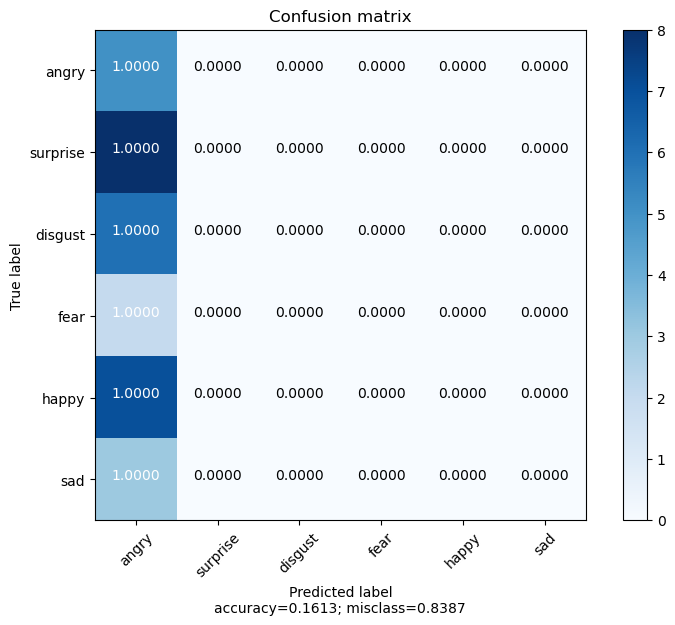

In [78]:
classes = ["angry", "surprise" , "disgust", "fear", "happy", "sad"]
plot_confusion_matrix(result2,classes)